In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import read_data
import gensim
from sklearn.decomposition import PCA

In [3]:
data_folder = 'data'
nrows = None
prior = read_data(data_folder=data_folder, nrows=nrows, read_prior=True)
train = read_data(data_folder=data_folder, nrows=nrows, read_train=True)

In [4]:
train['product_id'] = train['product_id'].astype('str')
prior['product_id'] = prior['product_id'].astype('str')

In [5]:
train_products = train.groupby('order_id')['product_id'].apply(lambda x: x.tolist()).reset_index()
prior_products = prior.groupby('order_id')['product_id'].apply(lambda x: x.tolist()).reset_index()

In [6]:
products = pd.concat([train_products, prior_products])
print(products.shape)

(3346083, 2)


In [7]:
products.head()

,order_id,product_id
0,1,"[49302, 11109, 10246, 49683, 43633, 13176, 472..."
1,36,"[39612, 19660, 49235, 43086, 46620, 34497, 486..."
2,38,"[11913, 18159, 4461, 21616, 23622, 32433, 2884..."
3,96,"[20574, 30391, 40706, 25610, 27966, 24489, 39275]"
4,98,"[8859, 19731, 43654, 13176, 4357, 37664, 34065..."


In [15]:
max_num_prods= len(max(products['product_id'], key=len))
max_num_prods

145

In [17]:
# model training
model = gensim.models.Word2Vec(sentences=products['product_id'], min_count=2, vector_size=100, window=max_num_prods, workers=8)

- `min_count` = 2 to ignore orders with only one product inside
- vector_size = 100, default size for the word vectors
- window =  max_num_prods because sequence of products added to cart are independent

In [32]:
model.wv.vectors.shape

(49583, 100)

In [31]:
len(model.wv.key_to_index.keys())

49583

In [22]:
model.wv

In [69]:
prods_embedding = pd.DataFrame(index=model.wv.key_to_index.keys(),
                              data=model.wv.vectors).rename_axis('product_id')
prods_embedding.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
product_id,,,,,,,,,,,,,,,,,,,,,
24852,1.159197,-2.160967,1.495495,-0.296739,-0.718408,0.789104,1.268353,-5.020040,2.734910,1.498530,...,-7.922766,-3.885876,-0.997543,-0.457081,-2.817929,-0.194468,1.230969,2.063094,-0.764989,2.076463
13176,2.973655,0.064563,2.968466,-0.998679,0.828710,1.664585,1.771862,-3.081510,0.605820,1.335214,...,-4.693273,-1.739104,-2.325253,0.634346,-2.051823,-2.950957,-2.346019,6.181652,-1.351458,1.919667
21137,1.197750,-0.813662,-1.010922,-2.067712,2.795329,0.628347,-4.244933,-3.276744,-1.626059,1.444797,...,0.862305,1.198506,-5.060522,-0.238246,-2.878265,-1.622982,-2.138012,0.596830,1.721767,-1.705115


In [59]:
def get_product_names(dic, pid):
    products=pd.read_pickle('data/products.pickle')[['product_id', 'product_name', 'aisle', 'department']]
    products['product_id'] = products['product_id'].astype('str')
    print(products.loc[products['product_id']==pid])
    return pd.DataFrame(dic, columns=['product_id', 'similarity']).merge(products)

In [61]:
pid = '24852'
dic = model.wv.most_similar(pid, topn=5)
get_product_names(dic, pid)

      product_id product_name         aisle department
24851      24852       Banana  fresh fruits    produce


,product_id,similarity,product_name,aisle,department
0,13176,0.786961,Bag of Organic Bananas,fresh fruits,produce
1,37067,0.576693,Organic Banana,fresh fruits,produce
2,41787,0.441308,Bartlett Pears,fresh fruits,produce
3,4920,0.424999,Seedless Red Grapes,packaged vegetables fruits,produce
4,20766,0.413209,Lentil & Quinoa Spaghetti,missing,missing


Top 5 products most similar to Banana are:
- Bag of Organic Bananas,
- Organic Banana
- Bartlett Pears
- Seedless Red Grapes
- Lentil & Quinoa Spaghetti

Because the model is trained based on orders of products, the top similar products can be alternatives for customers

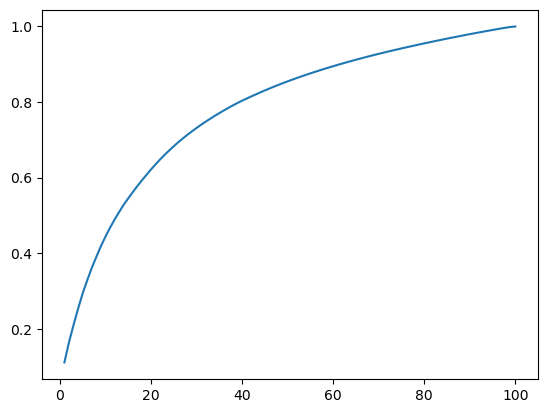

In [75]:
# to choose how many components we need
full_variance_explained = PCA().fit(prods_embedding.values).explained_variance_ratio_
plt.plot(range(1, prods_embedding.shape[1]+1, ), full_variance_explained.cumsum())

choose ~ 40 components to retain 80% of variance

In [77]:
n_components = np.argmax(np.cumsum(full_variance_explained) >= 0.80) + 1
n_components

40

In [80]:
# pca project data
pc = PCA(n_components, random_state=0).fit_transform(prods_embedding.values)
pc.shape

(49583, 40)

In [88]:
product_embedding = pd.DataFrame(index=prods_embedding.index, data=pc, columns=np.arange(pc.shape[1])).add_prefix('p_embedding_').reset_index()
product_embedding.head()

,product_id,p_embedding_0,p_embedding_1,p_embedding_2,p_embedding_3,p_embedding_4,p_embedding_5,p_embedding_6,p_embedding_7,p_embedding_8,...,p_embedding_30,p_embedding_31,p_embedding_32,p_embedding_33,p_embedding_34,p_embedding_35,p_embedding_36,p_embedding_37,p_embedding_38,p_embedding_39
0,24852,6.139562,8.247399,0.177175,6.872938,7.354549,6.022885,-0.749231,4.601255,1.275191,...,0.518159,0.914374,-0.216187,-2.143715,0.900467,-0.244941,-0.705107,0.792111,-3.226277,0.231244
1,13176,12.710593,1.934130,0.062299,5.112406,1.747958,-1.002434,3.030148,3.362142,0.964711,...,-1.053328,2.160508,-1.077320,0.955618,-0.760497,1.735387,0.873751,0.949630,-2.175238,-1.952513
2,21137,13.298876,5.852841,1.639925,5.413839,5.326396,-1.167076,2.368138,2.991443,0.442467,...,0.368765,2.555952,-1.412906,1.109960,0.495749,0.685554,0.368551,0.873338,-1.458324,-0.949680
3,21903,15.975659,4.615723,-1.187738,-2.274990,2.965997,4.637571,0.139672,1.635376,1.642688,...,0.376636,1.441471,1.076760,-0.680161,0.776902,0.201862,-1.081982,0.904838,0.653280,-1.780417
4,47209,17.089874,0.324996,-0.906168,2.592585,1.750579,1.774003,2.022659,1.855752,0.677757,...,0.784849,-0.182038,-2.316222,2.253558,-0.953431,1.538950,0.005801,-0.916378,-3.070594,-0.565279


In [90]:
# convert produc
product_embedding.product_id = product_embedding.product_id.astype(int)

In [94]:
product_embedding.to_pickle('data/product_embedding.pickle')